In [84]:
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
import scipy.sparse as sparse
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import GmGM
import math
import BiGLasso_Methods as bg
import scipy.stats as stats
import igraph as ig
from typing import Optional, Literal
import os

In [81]:
RESULTS_DIR = f"million-cell"

In [18]:
gene_ids = pd.read_csv('out/million-cell-genes.csv')
network = sparse.csr_matrix(sparse.load_npz("out/million-cell-genes.npz"))
network, gene_ids.columns

(<2200x2200 sparse matrix of type '<class 'numpy.float32'>'
 	with 8090 stored elements in Compressed Sparse Row format>,
 Index(['ensembl_id'], dtype='object'))

In [3]:
# Add gene names to the dataset

# Get names of genes from ensembl id
mapping = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "external_gene_name"],
)
mapping = mapping.set_index("ensembl_gene_id")
mapping = mapping[mapping.index.isin(gene_ids['ensembl_id'])]

mapping

,external_gene_name
ensembl_gene_id,
ENSG00000198804,MT-CO1
ENSG00000198692,EIF1AY
ENSG00000129824,RPS4Y1
ENSG00000233236,LINC02573
ENSG00000142149,HUNK
...,...
ENSG00000133069,TMCC2
ENSG00000230138,LINC02812
ENSG00000143001,TMEM61


In [4]:
names = gene_ids.join(mapping, on='ensembl_id')['external_gene_name']
names.fillna('unknown', inplace=True)
names

0        unknown
1           HES4
2          ISG15
3       TNFRSF18
4        TNFRSF4
          ...   
2195        MPP1
2196       CLIC2
2197      RPS4Y1
2198      EIF1AY
2199      MT-CO1
Name: external_gene_name, Length: 2200, dtype: object

In [36]:
def plot_info(
    name: str,
    graph: sparse.spmatrix,
    labels: pd.Series,
    no_edge_weights: bool = True,
    layout: Optional[str] = None,
    circsize: int = 15,
    fig: plt.Figure = None,
    ax: plt.Axes = None
) -> tuple[plt.Figure, plt.Axes]:
    how_many = graph.shape[0]

    try:
        # If the graph is empty, this throws an error!
        graph = ig.Graph.Weighted_Adjacency(graph, mode="undirected").simplify()
    except:
        graph = ig.Graph.Weighted_Adjacency(graph)

    graph.vs["label"] = labels

    uniques = list(set(graph.vs["label"]))

    # Get rid of alleles
    graph.contract_vertices(
        [uniques.index(_) for _ in graph.vs["label"]],
        combine_attrs="first"
    )
    graph = graph.simplify()

    graph.vs["label_size"] = 4

    for idx, vertex in enumerate(graph.vs):
        if len(vertex["label"]) > 5:
            graph.vs[idx]["label_size"] = 3
        if len(vertex["label"]) > 7:
            graph.vs[idx]["label_size"] = 2

    # Color vertex by component
    graph.vs["color"] = "#FF9A96"

    # Change  vertex shape by component as well
    graph.vs["shape"] = "rect"

    try:
        graph.es["label"] = [f"{w:.2E}" for w in graph.es["weight"]]
        graph.es["label_size"] = 5
    except:
        pass

    if layout is None:
        layout = 'circle' if how_many > 15 else 'kk'


    if fig is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    
    num_full_components = len([_ for _ in graph.components() if len(_) > 1])
    num_singletons = len([_ for _ in graph.components() if len(_) < 2])
    full_components = 0
    singletons = 0
    singleton_inset = ax.inset_axes([1, 0, 0.4, 1])
    singleton_inset.axis("off")
    singleton_inset.set_title("Singletons")
    singleton_inset.axvline(0, color="black", linestyle='--')
    for component in graph.components():
        if len(component) < 2:
            singleton_divisor = (num_singletons - 1) // 9 + 1
            inset_inset = singleton_inset.inset_axes([
                (singletons) % singleton_divisor * 0.23 - 0.35,
                0.9 - singletons // singleton_divisor * 0.1,
                1,
                0.1
            ])
            ig.plot(
                graph.subgraph(component),
                vertex_size=circsize,
                target=inset_inset,
                edge_color="black",
                layout=layout,
                **({} if no_edge_weights else {'edge_label': graph.es["label"]}),
            )
            inset_inset.set_facecolor("#00000000")
            inset_inset.axis("off")
            singletons += 1
            continue
        subgraph = graph.subgraph(component)
        divisor = int(np.ceil(np.sqrt(num_full_components)))
        size = 1 / divisor
        ax_inset = ax.inset_axes([
            size * (full_components % divisor),
            -size * ((full_components) // divisor) + 1 - size,
            size,
            size
        ])
        subgraph.vs["shape"] = "circle"
        ig.plot(
            subgraph,
            vertex_size=circsize,
            target=ax_inset,
            edge_color="black",
            layout=layout,
            **({} if no_edge_weights else {'edge_label': subgraph.es["label"]}),
        )
        
        ax_inset.set_facecolor("#00000000")
        ax_inset.axis("off")
        full_components += 1

    # If no components, put a N/A in graph
    if num_full_components == 0:
        ax_inset = ax.inset_axes([0, 0, 1, 1])
        ax_inset.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=20, color='grey')
        ax_inset.axis("off")

    ax.set_xlabel("Colored/shaped by connected components")
    ax.axis("off")

    ax.set_title(name)
    
    return fig, ax

# Results

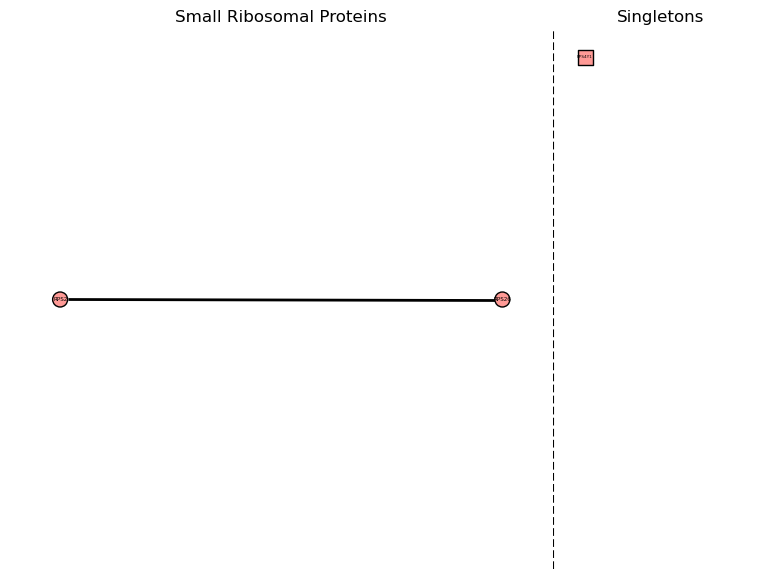

In [44]:
ribosomal_small = names[names.str.startswith("RPS")]

fig, ax = plot_info(
    "Small Ribosomal Proteins",
    network[names.isin(ribosomal_small)][:, names.isin(ribosomal_small)],
    ribosomal_small.values,
    layout='circle',
    circsize=15
)
fig.savefig("out-figs/million-cell/ribosomal-small.pdf", dpi=300, bbox_inches='tight')
pass

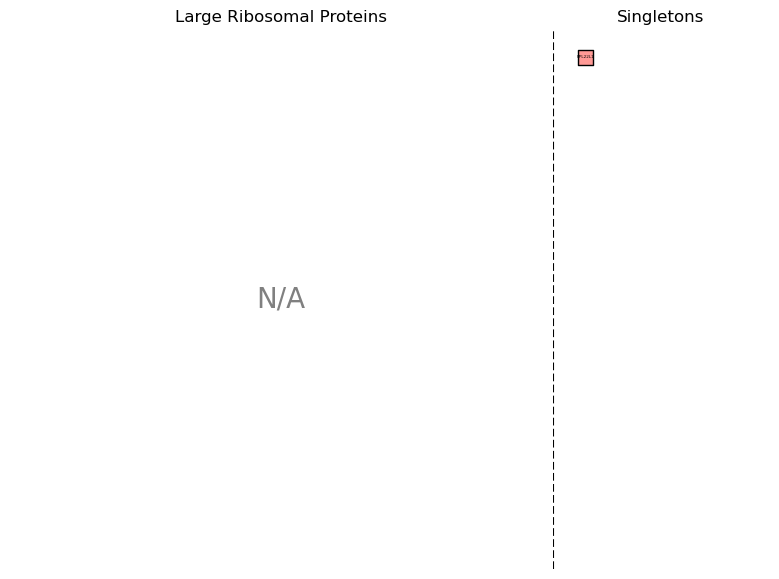

In [43]:
ribosomal_large = names[names.str.startswith("RPL")]

fig, ax = plot_info(
    "Large Ribosomal Proteins",
    network[names.isin(ribosomal_large)][:, names.isin(ribosomal_large)],
    ribosomal_large.values,
    layout='circle',
    circsize=15
)
fig.savefig("out-figs/million-cell/ribosomal-large.pdf", dpi=300, bbox_inches='tight')
pass

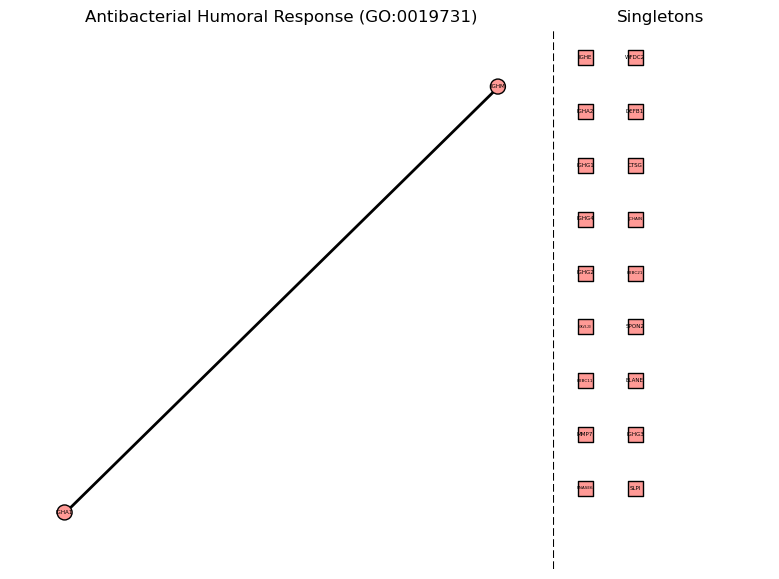

In [48]:
# antibacterial humoral response, GO:0019731

goid = [
    "HLA-A","SPRR2A","RNASE3","SEMG1","CAMP","DEFB1","BPIFA1","HLA-E","H2BC21",
    "PLA2G1B","RNASE7","DMBT1","WFDC11","WFDC9","RNASE4","WFDC10A","RNASE6","SEMG2","H2BC12L",
    "SLPI","ANG","SPON2","NOD2","H2BC11","FGA","IGHA2","IGHA1","IGHM","IGHG4",
    "IGHG3","IGHG2","IGHG1","IGHE","TF","IGKV3-20","JCHAIN","ELANE","RPL39","FAU",
    "H2BC10","CTSG","MMP7","DEFA6","DEFA5","WFDC2","DEFA3","DEFA1","NCR3LG1","H2BC12",
    "LTF","PLA2G6","FGB","WFDC13","WFDC10B","WFDC3","PI3","LGALS4","WFDC5","DEFA4",
    "WFDC12",
]
goid_results = names[names.isin(goid)]

fig, ax = plot_info(
    "Antibacterial Humoral Response (GO:0019731)",
    network[names.isin(goid_results)][:, names.isin(goid_results)],
    goid_results.values,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/million-cell/antibacterial-humoral.pdf", dpi=300, bbox_inches='tight')
pass

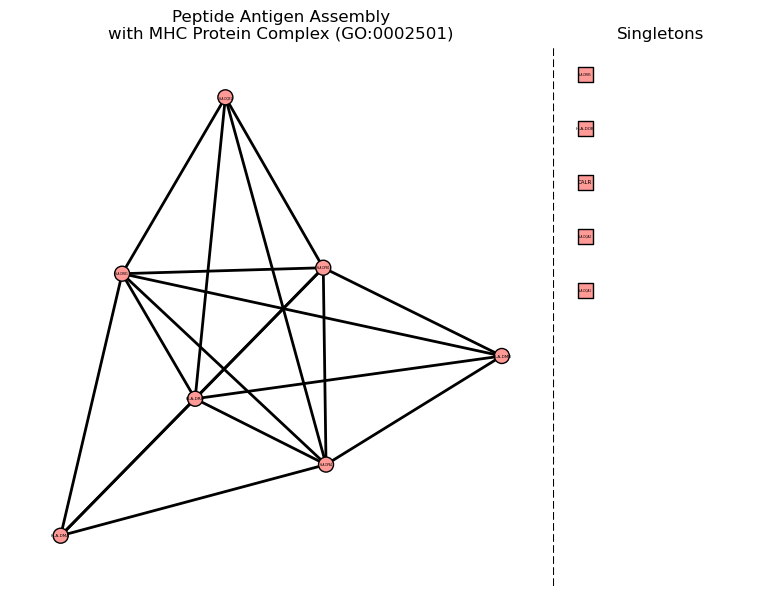

In [59]:
# antibacterial humoral response, GO:0019731

goid = [
    "HLA-DMA","HLA-DRA","B2M","HLA-DPB1","HLA-A","TAPBP","HLA-DRB5",
    "HLA-DQB1","HLA-DQA1","HLA-DQA2","HLA-DRA","CALR","PDIA3","HLA-DOB",
    "HLA-DRB4","HLA-DPA1","HLA-DRB3","HLA-DQB2","HLA-DOA","HLA-DRB1",
    "TAPBPL","HLA-DMB"
]
goid_results = names[names.isin(goid)]

fig, ax = plot_info(
    "Peptide Antigen Assembly\nwith MHC Protein Complex (GO:0002501)",
    network[names.isin(goid_results)][:, names.isin(goid_results)],
    goid_results.values,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/million-cell/mhc.pdf", dpi=300, bbox_inches='tight')
pass

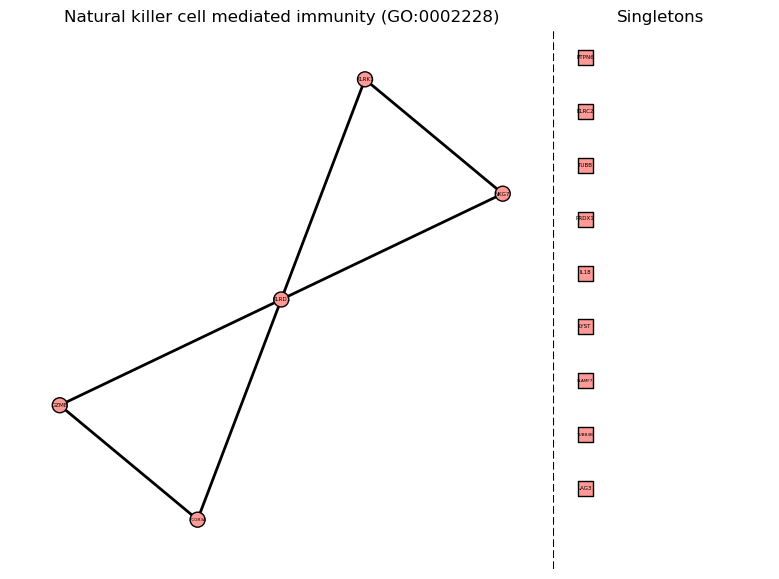

In [62]:
# natural killer cell mediated immunity, GO:0002228

goid = [
    "PLEKHM2","VAMP7","TUBB4B","CORO1A","CLEC2A","IL18","FCGR3A","ARL8B","KLRD1",
    "PRDX1","NKG7","SLAMF7","PIK3R1","RAET1G","GZMB","RAB27A","TUBB","HCST","MICA",
    "KIF5B","CD2","CEBPG","KIR3DL1","UNC13D","GRB2","LAG3","PTPN6","KLRF2","SH2D1A",
    "VAV1","KLRK1","KLRC2","ULBP1","ULBP2","ULBP3","LYST","RAET1E","RNF19B","STAT5B",
]
goid_results = names[names.isin(goid)]

fig, ax = plot_info(
    "Natural killer cell mediated immunity (GO:0002228)",
    network[names.isin(goid_results)][:, names.isin(goid_results)],
    goid_results.values,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/million-cell/nk-immune.pdf", dpi=300, bbox_inches='tight')
pass

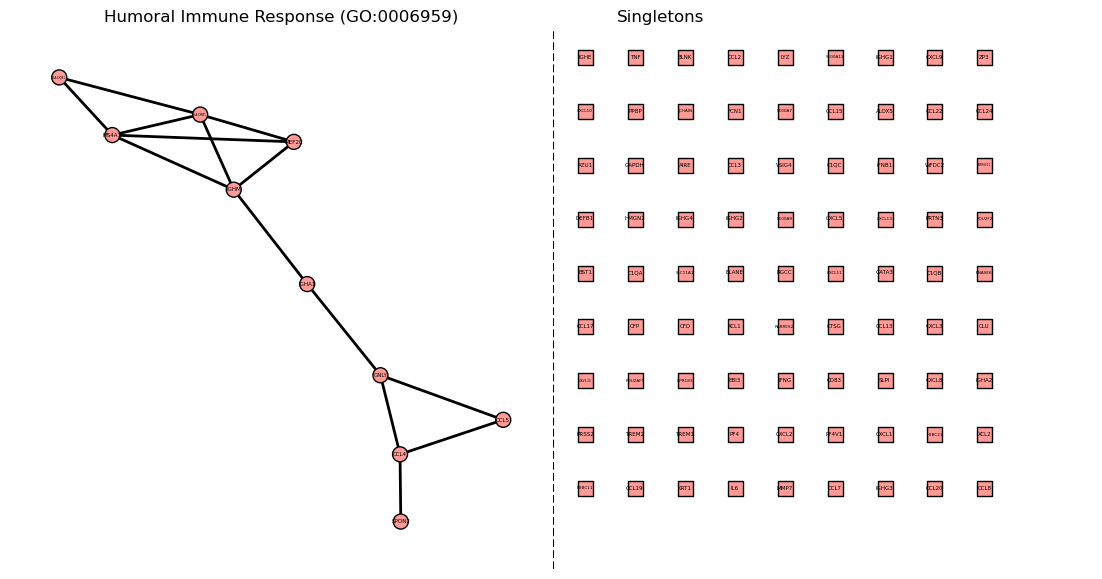

In [64]:
# humoral immune response, GO:0006959

goid = [
    "MUC7","POU2F2","CCL13","CCR2","BLNK","IFNE","LYZ","HLA-A","GAPDH",
    "CCL11","S100A7","REG3G","SPRR2A","CCL18","CCL23","BMI1","EBI3","RNASE3","CFP",
    "PRSS3","HLA-DQB1","CFH","SEMG1","KRT1","CCL16","CCL25","HRG","PRTN3","CAMP",
    "DEFB118","FAM3A","DEFB1","CD81","BPIFA1","MEF2C","FCN3","CCL15","C8A","CCL14",
    "EXO1","HLA-E","PGLYRP3","PGLYRP4","RGCC","RBPJ","PGLYRP1","TNFRSF21","CST9L","H2BC21",
    "CFB","TREM1","CFD","C1R","F2","C1RL","TREM2","DEFB4A","PLA2G1B","C4BPA",
    "CCL4","CCL4L1","XCL1","CXCL8","COLEC10","YTHDF2","CCL3","BCL3","DEFB127","CD28",
    "RNASE7","C4BPB","C7","DMBT1","WFDC11","WFDC9","CXCL14","BCL2","IL7","S100A12",
    "CR1","ROMO1","RNASE4","C8B","C8G","CFHR3","WFDC10A","RNASE6","CLU","PRSS2",
    "POU2AF1","PSMB10","VSIG4","CCL26","XCL2","GALP","AZU1","PF4V1","C6","SEMG2",
    "CCL5","CCL2","GATA3","H2BC12L","CXCL11","LEAP2","REG3A","SLPI","CR2","ANG",
    "SPON2","NOD2","CFHR1","TSLP","CCL7","CCL8","H2BC11","CX3CL1","GPI","S100A9",
    "FGA","IGHA2","IGHA1","IGHM","IGHG4","IGHG3","IGHG2","IGHG1","IGHE","C1QA",
    "C1QB","PPBP","CXCL10","TF","IFNK","CST9LP1","CST9","IGKV3-20","CXCL9","JCHAIN",
    "IFNG","IFNB1","IFNA17","IFNA14","IFNA5","IFNA21","IFNA7","IFNA10","IFNA2","IFNA1",
    "ELANE","CFI","SERPING1","IFNA16","IFNA4","IFNA6","IFNW1","IFNA8","CD83","CXCL13",
    "AIRE","RPS19","CD46","SLC11A1","GPR183","RPL39","FAU","H2BC10","C4B","CD55",
    "TNF","LTA","ALOX5","NOTCH1","C1QBP","CCL1","CXCL5","TRAF3IP2","IL36RN","SUSD4",
    "CTSG","CFHR2","CCL20","C4A","ST6GAL1","RPL30","REG1A","NOTCH2","C5","C3",
    "MBL2","KRT6A","MMP7","TFEB","DEFA6","DEFA5","SH2D1A","CXCL6","IL6","WFDC2",
    "HMGN2","DEFA3","DEFA1","PDCD1","MASP1","NCR3LG1","H2BC12","LTF","PF4","C9",
    "C1QC","PLA2G6","FGB","HLA-DRB1","CCL21","C2","CFHR4","WFDC13","WFDC10B","WFDC3",
    "FOXJ1","CFHR5","PI3","MS4A1","COLEC11","LGALS4","CXCL3","CXCL2","SPAG11B","REG1B",
    "CCL19","FCN2","WFDC5","CCL17","GNLY","CXCL1","FCMR","DEFA4","TFE3","CCR6",
    "CCL22","WFDC12","CCL3L1","FCN1","RARRES2","SPAG11A","DEFB126","C1S","BST1","ZP3",
    "MASP2","CCL24",
]
goid_results = names[names.isin(goid)]

plot_info(
    "Humoral Immune Response (GO:0006959)",
    network[names.isin(goid_results)][:, names.isin(goid_results)],
    goid_results.values,
    layout='fr',
    no_edge_weights=True
)
pass

# Together

In [65]:
goid_0019731 = [
    "HLA-A","SPRR2A","RNASE3","SEMG1","CAMP","DEFB1","BPIFA1","HLA-E","H2BC21",
    "PLA2G1B","RNASE7","DMBT1","WFDC11","WFDC9","RNASE4","WFDC10A","RNASE6","SEMG2","H2BC12L",
    "SLPI","ANG","SPON2","NOD2","H2BC11","FGA","IGHA2","IGHA1","IGHM","IGHG4",
    "IGHG3","IGHG2","IGHG1","IGHE","TF","IGKV3-20","JCHAIN","ELANE","RPL39","FAU",
    "H2BC10","CTSG","MMP7","DEFA6","DEFA5","WFDC2","DEFA3","DEFA1","NCR3LG1","H2BC12",
    "LTF","PLA2G6","FGB","WFDC13","WFDC10B","WFDC3","PI3","LGALS4","WFDC5","DEFA4",
    "WFDC12",
]
goid_0006959 = [
    "MUC7","POU2F2","CCL13","CCR2","BLNK","IFNE","LYZ","HLA-A","GAPDH",
    "CCL11","S100A7","REG3G","SPRR2A","CCL18","CCL23","BMI1","EBI3","RNASE3","CFP",
    "PRSS3","HLA-DQB1","CFH","SEMG1","KRT1","CCL16","CCL25","HRG","PRTN3","CAMP",
    "DEFB118","FAM3A","DEFB1","CD81","BPIFA1","MEF2C","FCN3","CCL15","C8A","CCL14",
    "EXO1","HLA-E","PGLYRP3","PGLYRP4","RGCC","RBPJ","PGLYRP1","TNFRSF21","CST9L","H2BC21",
    "CFB","TREM1","CFD","C1R","F2","C1RL","TREM2","DEFB4A","PLA2G1B","C4BPA",
    "CCL4","CCL4L1","XCL1","CXCL8","COLEC10","YTHDF2","CCL3","BCL3","DEFB127","CD28",
    "RNASE7","C4BPB","C7","DMBT1","WFDC11","WFDC9","CXCL14","BCL2","IL7","S100A12",
    "CR1","ROMO1","RNASE4","C8B","C8G","CFHR3","WFDC10A","RNASE6","CLU","PRSS2",
    "POU2AF1","PSMB10","VSIG4","CCL26","XCL2","GALP","AZU1","PF4V1","C6","SEMG2",
    "CCL5","CCL2","GATA3","H2BC12L","CXCL11","LEAP2","REG3A","SLPI","CR2","ANG",
    "SPON2","NOD2","CFHR1","TSLP","CCL7","CCL8","H2BC11","CX3CL1","GPI","S100A9",
    "FGA","IGHA2","IGHA1","IGHM","IGHG4","IGHG3","IGHG2","IGHG1","IGHE","C1QA",
    "C1QB","PPBP","CXCL10","TF","IFNK","CST9LP1","CST9","IGKV3-20","CXCL9","JCHAIN",
    "IFNG","IFNB1","IFNA17","IFNA14","IFNA5","IFNA21","IFNA7","IFNA10","IFNA2","IFNA1",
    "ELANE","CFI","SERPING1","IFNA16","IFNA4","IFNA6","IFNW1","IFNA8","CD83","CXCL13",
    "AIRE","RPS19","CD46","SLC11A1","GPR183","RPL39","FAU","H2BC10","C4B","CD55",
    "TNF","LTA","ALOX5","NOTCH1","C1QBP","CCL1","CXCL5","TRAF3IP2","IL36RN","SUSD4",
    "CTSG","CFHR2","CCL20","C4A","ST6GAL1","RPL30","REG1A","NOTCH2","C5","C3",
    "MBL2","KRT6A","MMP7","TFEB","DEFA6","DEFA5","SH2D1A","CXCL6","IL6","WFDC2",
    "HMGN2","DEFA3","DEFA1","PDCD1","MASP1","NCR3LG1","H2BC12","LTF","PF4","C9",
    "C1QC","PLA2G6","FGB","HLA-DRB1","CCL21","C2","CFHR4","WFDC13","WFDC10B","WFDC3",
    "FOXJ1","CFHR5","PI3","MS4A1","COLEC11","LGALS4","CXCL3","CXCL2","SPAG11B","REG1B",
    "CCL19","FCN2","WFDC5","CCL17","GNLY","CXCL1","FCMR","DEFA4","TFE3","CCR6",
    "CCL22","WFDC12","CCL3L1","FCN1","RARRES2","SPAG11A","DEFB126","C1S","BST1","ZP3",
    "MASP2","CCL24",
]

goid_0002501 = [
    "HLA-DMA","HLA-DRA","B2M","HLA-DPB1","HLA-A","TAPBP","HLA-DRB5",
    "HLA-DQB1","HLA-DQA1","HLA-DQA2","HLA-DRA","CALR","PDIA3","HLA-DOB",
    "HLA-DRB4","HLA-DPA1","HLA-DRB3","HLA-DQB2","HLA-DOA","HLA-DRB1",
    "TAPBPL","HLA-DMB"
]

goid_0002275 = [
    "PTGDR", "LYN", "LBP", "CL2ORF4","SBNO2","SCNN1B","ITGB2","SYK",
    "IL13RA2","ADGRE2","VAMP7","IGHE","BCR","CHGA","PTAFR","PRKCE",
    "FOXF1","SLC18A2","CCL3","SNX4","STX4","PTGDS","SUCNR1","PYCARD",
    "CD177","GRP","LILRA2","RAC2","KARS1","IFI35","ITGAM","PLA2G3",
    "PDPK1","PRAM1","SPHK2","FES","LAT2","SCN11A","BTK",
    "GPR15LG","STXBP3","MILR1","TYROBP","ANXA3","RABGEF1","PTPN6",
    "NR4A3","GATA1","KIT","CLNK","FCER1G","RASGRP1","DNASE1","DNASE1L3",
    "SNAP23","RAB44","TREX1","CCR2","TNF","CD300A","NMI","IL4","LAT",
    "STXBP1","IL4R","PIK3CG","IL33","PLCG2","FGR","TICAM1","STXBP2",
    "MRGPRX2","ENPP3","LGALS9","GAB2","UNC13D","CX3CR1","TREM2",
    "S100A13","FCER1A","IL13","FER","CBL","F2RL1","SLAMF1","DOCK2","IFNG",
    "VAMP8","HAVCR2","CPLX2","ADORA2B","SPI1","GRN","GATA2","MYD88",
    "VAMP2","CD84","PIK3CD","DYSF"
]

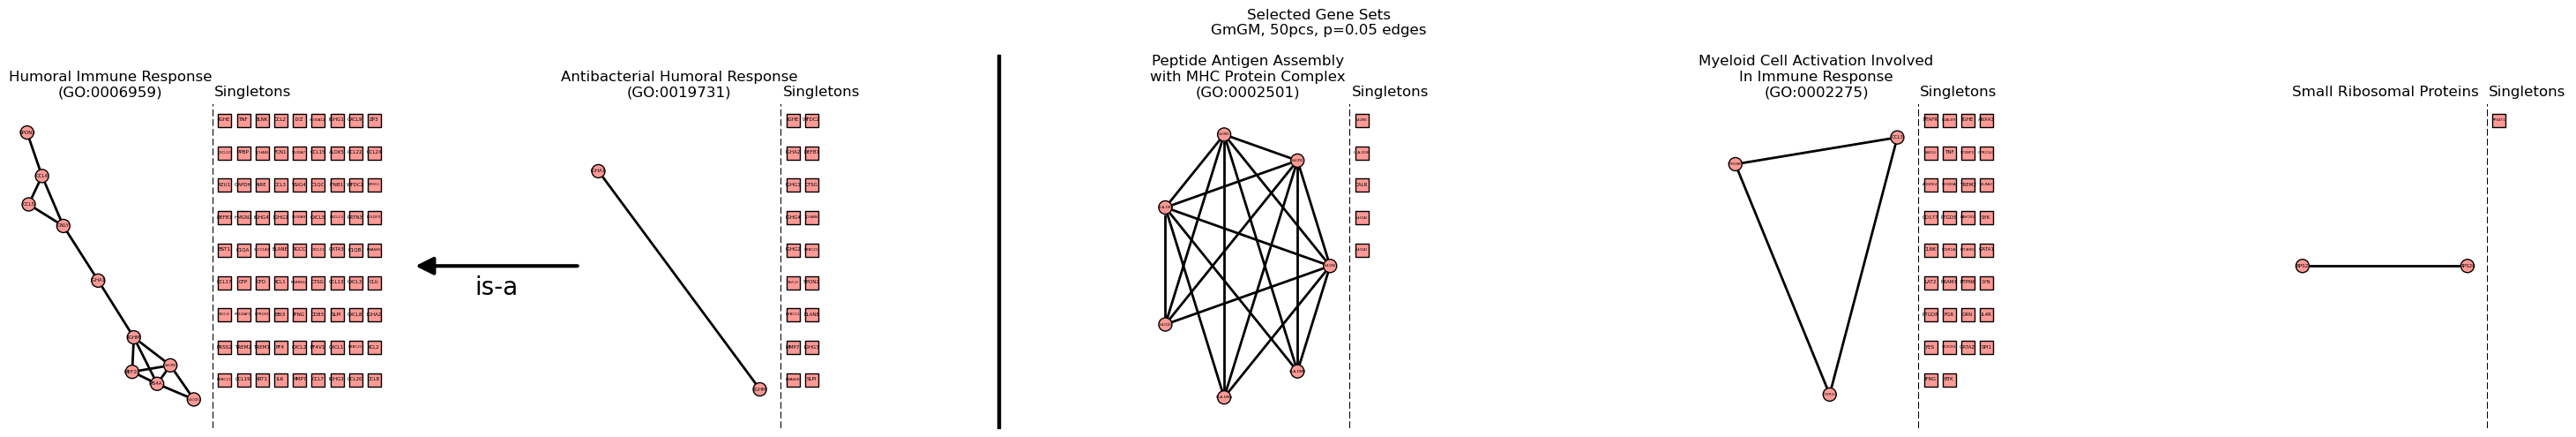

In [72]:
fig, axs = plt.subplots(figsize=(30, 5), nrows=1, ncols=5)

ribosomal_small = names[names.str.startswith("RPS")]
plot_info(
    "Small Ribosomal Proteins",
    network[names.isin(ribosomal_small)][:, names.isin(ribosomal_small)],
    ribosomal_small.values,
    layout='circle',
    circsize=15,
    fig=fig,
    ax=axs[4]
)


goid_results = names[names.isin(goid_0019731)]

plot_info(
    "Antibacterial Humoral Response\n(GO:0019731)",
    network[names.isin(goid_results)][:, names.isin(goid_results)],
    goid_results.values,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[1]
)

goid_results = names[names.isin(goid_0006959)]

plot_info(
    "Humoral Immune Response\n(GO:0006959)",
    network[names.isin(goid_results)][:, names.isin(goid_results)],
    goid_results.values,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[0]
)

goid_results = names[names.isin(goid_0002501)]

plot_info(
    "Peptide Antigen Assembly\nwith MHC Protein Complex\n(GO:0002501)",
    network[names.isin(goid_results)][:, names.isin(goid_results)],
    goid_results.values,
    layout='circle',
    no_edge_weights=True,
    circsize=15,
    fig=fig,
    ax=axs[2]
)

goid_results = names[names.isin(goid_0002275)]

plot_info(
    "Myeloid Cell Activation Involved\nIn Immune Response\n(GO:0002275)",
    network[names.isin(goid_results)][:, names.isin(goid_results)],
    goid_results.values,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[3]
)

fig.suptitle(f"Selected Gene Sets\nGmGM, 50pcs, p=0.05 edges")
fig.tight_layout()

# Draw is-a arrow
transFigure = fig.transFigure.inverted()
coord1 = transFigure.transform(axs[1].transData.transform([0, 0.5]))
coord2 = transFigure.transform(axs[0].transData.transform([2, 0.5]))
isa_arrow = patches.FancyArrowPatch(
    coord1,
    coord2,
    shrinkA=0,
    shrinkB=0,
    transform=fig.transFigure,
    color="black",
    arrowstyle="-|>",
    mutation_scale=30,
    linewidth=3,
)
fig.patches.append(isa_arrow)

# Add is-a label to it
isa_text = fig.text(
    0.5 * (coord1[0] + coord2[0]),
    0.5 * (coord1[1] + coord2[1]) - 0.05,
    "is-a",
    fontsize=20,
    ha='center',
    va='center',
    transform=fig.transFigure
)

# Add vertical bar between axs[1] and axs[2]
coord1 = transFigure.transform(axs[2].transData.transform([-0.6, 0]))
coord2 = transFigure.transform(axs[2].transData.transform([-0.6, 1.15]))
bar = patches.Rectangle(
    (coord1[0] - 0.01, coord1[1]),
    0.001,
    coord2[1] - coord1[1],
    transform=fig.transFigure,
    color="black"
)
fig.patches.append(bar)

fig.savefig("out-figs/million-cell/selected-gene-sets-million-cell.pdf", dpi=300, bbox_inches='tight')

pass

In [105]:
# Sparsity
numerator = (network + network.T).nnz
denominator = (network.shape[0] ** 2 - network.shape[0]) / 2
numerator, denominator, numerator / denominator

(5890, 2418900.0, 0.0024349911116623257)

# Modules

In [75]:
adata = ad.AnnData(
    X=np.zeros((network.shape[0], 1)),
    obs=pd.DataFrame(index=names),
)
adata.obs_names_make_unique()
adata

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 2200 × 1

In [76]:
adata.obsp["connectivities"] = network

In [77]:
sc.tl.leiden(
    adata,
    resolution=1,
    key_added="leiden_gene",
    obsp='connectivities',
    random_state=0
)

In [79]:
adata.obs['leiden_gene_processed'] = adata.obs['leiden_gene'].astype('category')
adata.obs['leiden_gene_processed'].cat.add_categories('Singleton', inplace=True)

valcounts = adata.obs['leiden_gene_processed'].value_counts()
adata.obs['leiden_gene_processed'][adata.obs['leiden_gene_processed'].isin(
    valcounts[valcounts <= 1].index
)] = 'Singleton'

adata.obs['leiden_gene_processed'] = adata.obs['leiden_gene_processed'].cat.remove_unused_categories()
adata.obs['leiden_gene_processed'].value_counts()

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_9998/296807315.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['leiden_gene_processed'].cat.add_categories('Singleton', inplace=True)


Singleton    1924
0              67
1              65
2              60
3              43
4              27
5              14
Name: leiden_gene_processed, dtype: int64

In [85]:
def create_pathway_df(
    adata: ad.AnnData,
    leiden_string: str = "leiden_gene_processed",
    save: bool = False,
    species: Literal["hsapiens", "mmusculus"] = "hsapiens",
) -> pd.DataFrame:
    gp = GProfiler(return_dataframe=True)
    pathway_df = gp.profile(
        organism=species,
        query={
            f"Module {module}": adata[adata.obs[leiden_string] == module].obs_names.values.tolist()
            for module in adata.obs[leiden_string].unique()
        },
    )
    if save:
        if not os.path.exists(RESULTS_DIR):
            os.makedirs(RESULTS_DIR)
        pathway_df.to_csv(f"./{RESULTS_DIR}/pathways.csv")
    return pathway_df

pathway_df = create_pathway_df(adata, save=True)

In [92]:
def plot_graph(
    module: str,
    full_graph: np.ndarray,
    name_source: pd.Series,
    top_pathways: int = 10,
    save: bool = False,
) -> tuple[tuple[plt.Figure, plt.Axes], ig.Graph]:

    

    uniques = list(set(name_source.tolist()))

    # Plot and save the graph
    graph = ig.Graph.Weighted_Adjacency(full_graph, mode="undirected").simplify()
    graph.contract_vertices(
        [uniques.index(_) for _ in name_source],
        combine_attrs="first"
    )
    graph.simplify()
    graph.vs["label"] = name_source
    graph.vs["label_size"] = 7
    fig, ax = plt.subplots(figsize=(7, 7))
    ig.plot(
        graph,
        vertex_size=50,
        target=ax,
        edge_color="black",
    )
    ax.set_facecolor("grey")
    ax.set_title(f"Module {module}")
    if save:
        # check if m{module} exists; if not, create it
        if not os.path.exists(f"./{RESULTS_DIR}/m{module}"):
            os.makedirs(f"./{RESULTS_DIR}/m{module}")
        
        plt.savefig(f"./{RESULTS_DIR}/m{module}/graph.png")

        # Select the top 10 pathways for relevant sources
        module_df = pathway_df[pathway_df["query"] == f"Module {module}"]
        res = pd.concat([
            module_df[module_df["source"] == "GO:BP"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "GO:CC"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "GO:MF"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "KEGG"].head(top_pathways)[["source", "native", "name", "p_value"]],
        ])
        res.to_csv(f"./{RESULTS_DIR}/m{module}/top_pathways.csv", index=False)

    return (fig, ax), graph


In [109]:
for module in adata.obs["leiden_gene_processed"].unique():
    if module == "Singleton":
        continue

    # Just look at top 10
    if module not in {"0", "1", "2", "3", "4", "5", "6", "7", "8", "9"}:
        continue

    (fig, _), _ = plot_graph(
        module,
        adata[adata.obs["leiden_gene_processed"] == module].obsp["connectivities"],
        name_source=adata[adata.obs["leiden_gene_processed"] == module].obs_names,
        top_pathways=10,
        save=True
    )

    # Close figures to prevent notebook slowing down.
    plt.close(fig)